# HHL Resource Estimation

Resource estimation asks how qubit counts and gate depths scale with problem size.

This notebook explores the Qiskit HHL implementation under a planar layout of qubits and a 5-10k 2-qubit gate budget to identify the classes of problems we can realistically target with current hardware.



In [1]:
# Switch to the parent directory
import sys
from pathlib import Path

repo_parent = Path().resolve().parents[1]
if str(repo_parent) not in sys.path:
    sys.path.append(str(repo_parent))

In [ ]:
# general imports
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
import qiskit.providers.fake_provider as fake_provider
import numpy as np
import matplotlib.pyplot as plt

# HHL circuit implementation
from QLSAs.circuits.hhl.qiskit_hhl_circuit import qiskit_hhl_circuit

# Random problem instance generator
from QLSAs.linear_systems_problems.random_matrix_generator import generate_problem

%config InlineBackend.figure_format = "retina"

In [3]:
# Example CNOT count for a 4x4 system
problem = generate_problem(4)
problem

{'A': array([[ 4.53899228e-01, -1.78541149e-01,  6.02032609e-17,
         -2.50433223e-01],
        [-1.78541149e-01,  4.43284111e-01, -4.43062566e-02,
          2.23612112e-16],
        [ 6.02032609e-17, -4.43062566e-02,  4.01095384e-01,
          2.15011646e-17],
        [-2.50433223e-01,  2.23612112e-16,  2.15011646e-17,
          4.93440584e-01]]),
 'b': array([-0.03609901,  0.16717238,  0.20185184, -0.11000011]),
 'csol': array([-0.05810003,  0.40853205,  0.54837921, -0.25241193]),
 'condition_number': 5.000000000000003,
 'sparsity': 0.0,
 'eigs': array([0.15493222, 0.38488085, 0.47724514, 0.7746611 ]),
 'bandwidth': 1}

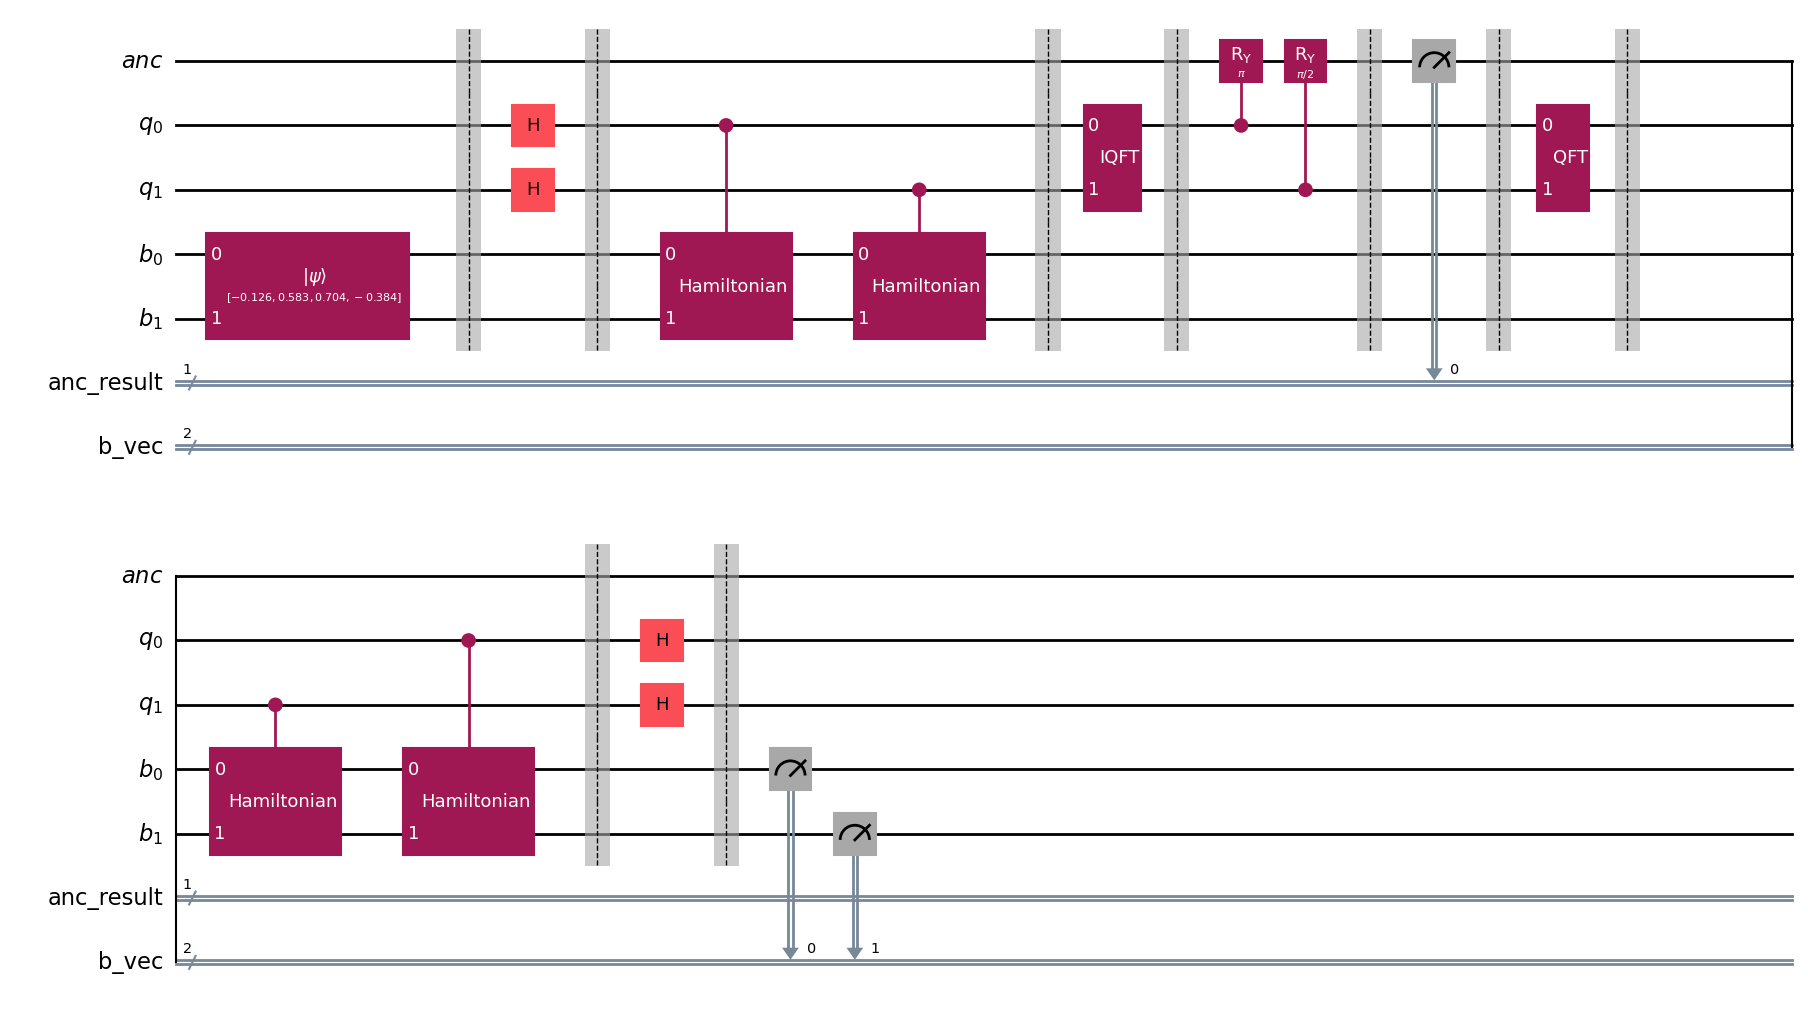

In [4]:
A = problem['A']
b = problem['b']
size = np.log2(len(b))

# Qiskit HHL circuit
hhl_circuit = qiskit_hhl_circuit(A = A, b = b, n_qpe_qubits = size)
hhl_circuit.draw(output = 'mpl')

In [ ]:
service = QiskitRuntimeService(name="QLSAs")
service.backends()

[<IBMBackend('ibm_pittsburgh')>,
 <IBMBackend('ibm_fez')>,
 <IBMBackend('ibm_torino')>,
 <IBMBackend('ibm_marrakesh')>,
 <IBMBackend('ibm_kingston')>]

In [6]:
backend = service.backend("ibm_pittsburgh")
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)

In [7]:
from qiskit_ibm_runtime import QiskitRuntimeService
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.visualization import plot_histogram
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_aer import AerSimulator
 
# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)
 
noise_model = NoiseModel.from_backend(backend)

In [ ]:
noise_model

<NoiseModel on ['reset', 'sx', 'x', 'measure', 'cz', 'id']>

In [8]:
print(noise_model)

NoiseModel:
  Basis gates: ['cz', 'delay', 'id', 'if_else', 'measure', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['reset', 'sx', 'x', 'measure', 'cz', 'id']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155]
  Specific qubit errors: [('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('reset', (5,)), ('reset', (6

In [7]:
physical_hhl_circuit = pm.run(hhl_circuit)
print(physical_hhl_circuit.count_ops())

OrderedDict([('sx', 444), ('rz', 381), ('cz', 188), ('x', 41), ('barrier', 9), ('measure', 3), ('reset', 2)])


# Now lets see what size problem we can solve with a budget of 5-10k CZ gates

In [8]:
sizes = [2, 4, 8, 16]
cz_counts = []

for problem_size in sizes:
    problem = generate_problem(problem_size)
    A = problem['A']
    b = problem['b']
    size = np.log2(len(b))
    hhl_circuit = qiskit_hhl_circuit(A = A, b = b, n_qpe_qubits = size)
    physical_hhl_circuit = pm.run(hhl_circuit)
    print(f"problem size: {problem_size}, cz count: {physical_hhl_circuit.count_ops()['cz']}")
    cz_counts.append(physical_hhl_circuit.count_ops()['cz'])

problem size: 2, cz count: 5
problem size: 4, cz count: 188
problem size: 8, cz count: 1888
problem size: 16, cz count: 12134


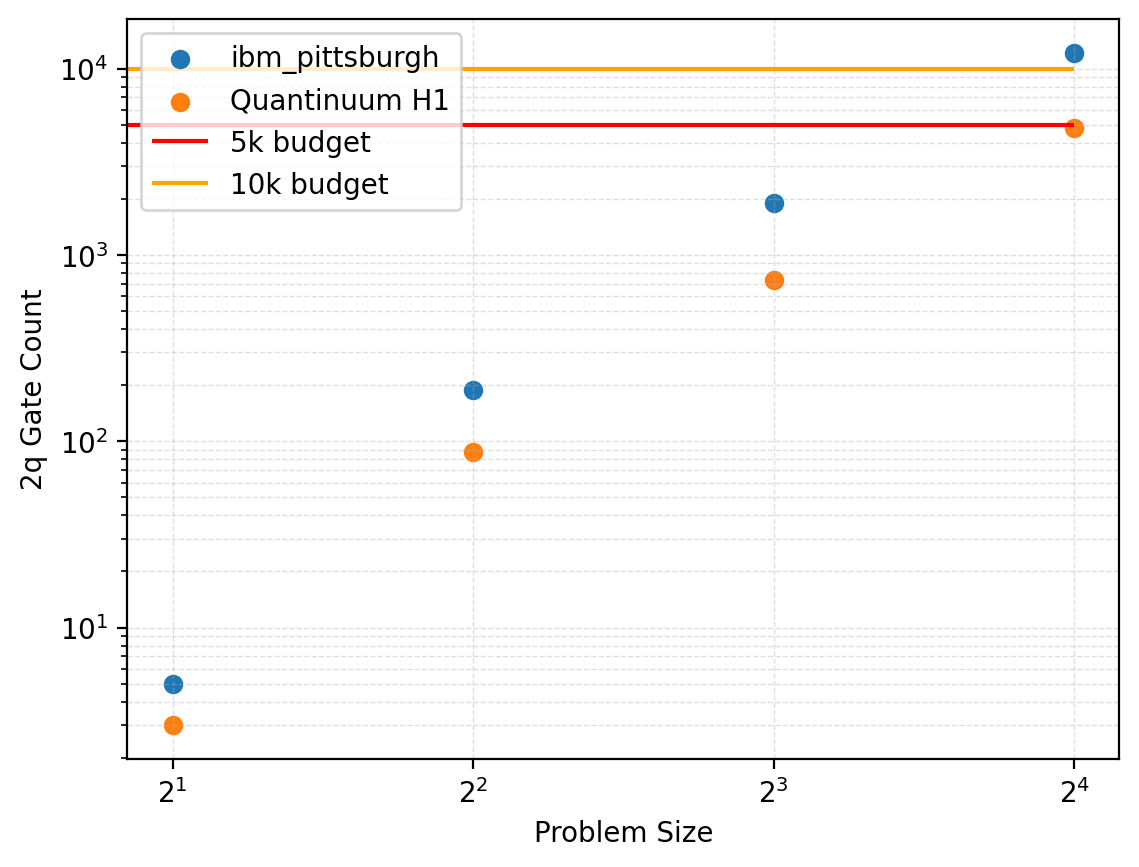

In [ ]:
# manually added from nexus
H1_2q_gate_counts = [3, 88, 736, 4819]

from matplotlib.ticker import LogLocator, FuncFormatter
def format_pow2(x, _pos):
    if x <= 0:
        return ""
    exponent = int(np.log2(x))
    coeff = x / 2**exponent
    coeff_str = "" if np.isclose(coeff, 1) else f"{coeff:g}×"
    return f"{coeff_str}2^{exponent}"

ax = plt.gca()
ax.set_xscale('log', base=2)              # use powers of 2
ax.xaxis.set_major_locator(LogLocator(base=2))  # ticks at 2^n
ax.xaxis.set_major_formatter(FuncFormatter(format_pow2))

plt.scatter(sizes, cz_counts, label = backend.name)
plt.scatter(sizes, H1_2q_gate_counts, label = 'Quantinuum H1')
plt.hlines(5000, 0, sizes[-1], color = 'red', label = '5k budget')
plt.hlines(10000, 0, sizes[-1], color = 'orange', label = '10k budget')
plt.xscale('log', base=2)
plt.yscale('log')
plt.xlabel('Problem Size')
plt.ylabel('2q Gate Count')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.4)
plt.legend()
plt.show()